In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nengo; assert nengo.version.version_info == (2, 8, 0)
import nengolib; assert nengolib.version.version_info >= (0, 5, 2)
import nengo_loihi; assert nengo_loihi.version.version_info >= (0, 7, 0)

In [3]:
# https://github.com/nengo/nengo-loihi/issues/230#issuecomment-501916092
# jupyter-specific: guard against this cell being re-run
if 'orig_build_chip_connection' not in locals():
    orig_build_chip_connection = (
        nengo_loihi.builder.connection.build_chip_connection)

    def monkeypatched_build_chip_connection(model, conn):
        # https://github.com/nengo/nengo-loihi/issues/230
        if (isinstance(conn.pre, nengo.Ensemble)
                and isinstance(conn.post, nengo.Ensemble)):
            print("Forcing neuron-to-neuron: %s" % conn)
            conn.solver = nengo.solvers.LstsqL2(weights=True)
        return orig_build_chip_connection(model, conn)

    nengo_loihi.builder.connection.build_chip_connection = (
        monkeypatched_build_chip_connection)

In [4]:
theta = 1.0  # length of window
freq = 1     # highest frequency to be kept in memory
order = 6    # number of Legendre polynomials representing window
sim_t = 50   # length of simulation
rms = 0.30   # amplitude of input (set to keep within [-1, 1])
tau = 0.1    # synaptic time-constant for population
dt = 0.001   # simulation time-step
seed = 0     # fixed for deterministic results
use_loihi = True  # whether to use Loihi hardware
use_discrete_principle3 = True  # discrete-simulator trick
move_tau_to_generator = True    # Loihi-specific trick
assert use_loihi if move_tau_to_generator else True

process = nengo.processes.WhiteSignal(
    high=freq, period=sim_t, rms=rms, y0=0, seed=seed)

sys = nengolib.synapses.LegendreDelay(
    theta=theta, order=order)

print("Approximants yield %.2f%% error" % (
    100 * np.abs(nengolib.synapses.pade_delay_error(
        theta_times_freq=theta*freq, order=order))))

Approximants yield 0.70% error


In [5]:
if use_discrete_principle3:
    # Voelker (2019; eq 5.9)
    discrete_sys = nengolib.signal.cont2discrete(
        sys, dt=dt, method='zoh')
    a = np.exp(-dt / tau)
    A = 1 / (1 - a) * (discrete_sys.A - a*np.eye(len(sys)))
    B = 1 / (1 - a) * discrete_sys.B
else:
    # Eliasmith and Anderson (2003)
    A = tau*sys.A + np.eye(len(sys))
    B = tau*sys.B 

with nengo.Network(seed=seed) as model:
    stim = nengo.Node(output=process)

    x = nengo.networks.EnsembleArray(
        n_neurons=100,
        n_ensembles=len(sys),
        ens_dimensions=1,
        max_rates=nengo.dists.Uniform(100, 120),
        intercepts=nengo.dists.Uniform(-1, 0.5),
        neuron_type=nengo.SpikingRectifiedLinear(),
    )

    conn_in = nengo.Connection(
        pre=stim,
        post=x.input,
        transform=B,
        synapse=None if move_tau_to_generator else tau,
    )
    conn_rec = nengo.Connection(
        pre=x.output,
        post=x.input,
        transform=A,
        synapse=tau,
    )
    
    p_stim = nengo.Probe(stim, synapse=None)
    p_x = nengo.Probe(x.output, synapse=None)

In [6]:
if move_tau_to_generator:
    print("Running modified-generator Loihi simulation")
    # https://github.com/nengo/nengo-loihi/issues/115#issuecomment-447015272
    # Note: this also affects the tau of all DecodeNeurons if weights=False
    # on any decoded connections
    loihi_model = nengo_loihi.builder.Model()
    assert loihi_model.decode_tau == 0.005
    loihi_model.decode_tau = tau
    factory = lambda model: nengo_loihi.Simulator(
        model, model=loihi_model, precompute=True, remove_passthrough=True)

elif use_loihi:
    print("Running normal Loihi simulation")
    factory = lambda model: nengo_loihi.Simulator(
        model, precompute=True, remove_passthrough=True)

else:
    print("Running normal Nengo simulation")
    factory = nengo.Simulator

with factory(model) as sim:
    assert sim.dt == dt
    sim.run(sim_t)

Running modified-generator Loihi simulation
Forcing neuron-to-neuron: <Connection from <Ensemble "1"> to <Ensemble "3">>
Forcing neuron-to-neuron: <Connection from <Ensemble "2"> to <Ensemble "2">>
Forcing neuron-to-neuron: <Connection from <Ensemble "3"> to <Ensemble "3">>
Forcing neuron-to-neuron: <Connection from <Ensemble "3"> to <Ensemble "1">>
Forcing neuron-to-neuron: <Connection from <Ensemble "3"> to <Ensemble "5">>
Forcing neuron-to-neuron: <Connection from <Ensemble "3"> to <Ensemble "4">>
Forcing neuron-to-neuron: <Connection from <Ensemble "2"> to <Ensemble "4">>
Forcing neuron-to-neuron: <Connection from <Ensemble "4"> to <Ensemble "2">>
Forcing neuron-to-neuron: <Connection from <Ensemble "4"> to <Ensemble "0">>
Forcing neuron-to-neuron: <Connection from <Ensemble "4"> to <Ensemble "5">>
Forcing neuron-to-neuron: <Connection from <Ensemble "4"> to <Ensemble "3">>
Forcing neuron-to-neuron: <Connection from <Ensemble "4"> to <Ensemble "4">>
Forcing neuron-to-neuron: <Conne

/home/arvoelke/git/nengo-loihi/nengo_loihi/discretize.py:459: UserWarning: Lost 4 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/home/arvoelke/git/nengo-loihi/nengo_loihi/discretize.py:459: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/home/arvoelke/git/nengo-loihi/nengo_loihi/discretize.py:459: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/home/arvoelke/git/nengo-loihi/nengo_loihi/discretize.py:459: UserWarning: Lost 3 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/home/arvoelke/git/nengo-loihi/nengo_loihi/discretize.py:459: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.42.0.100:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.86s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.92s)
INFO:DRV:      Initializing... Done (0.02s)
INFO:DRV:      Preparing input... Done (8.23s)
INFO:DRV:      Executing... Done (27.64s)
INFO:DRV:      Processing timeSeries... Done (45.01s)
INFO:DRV:  N2Driver: Finished (82.70s)


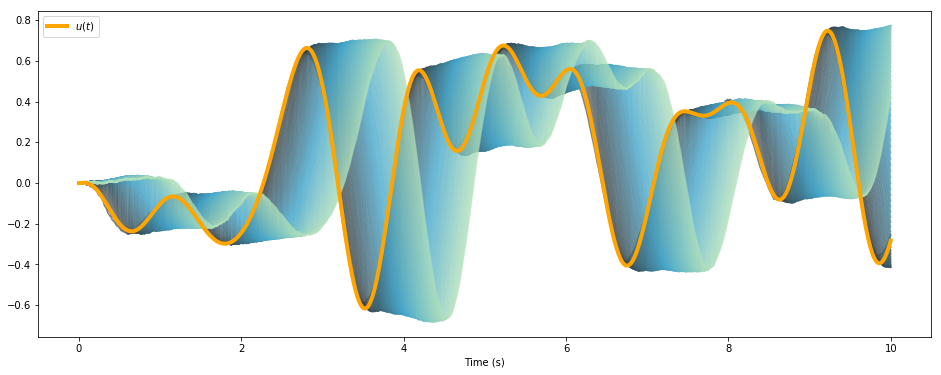

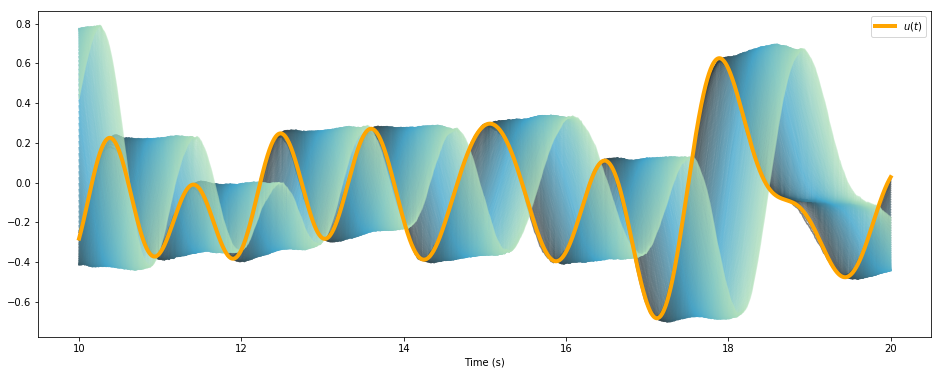

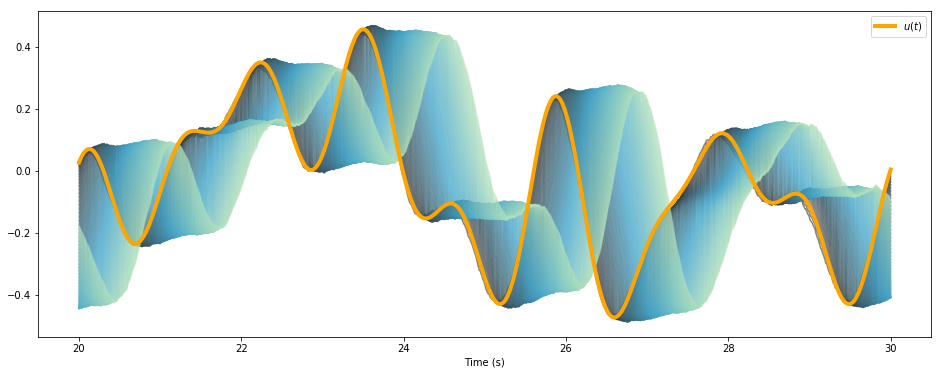

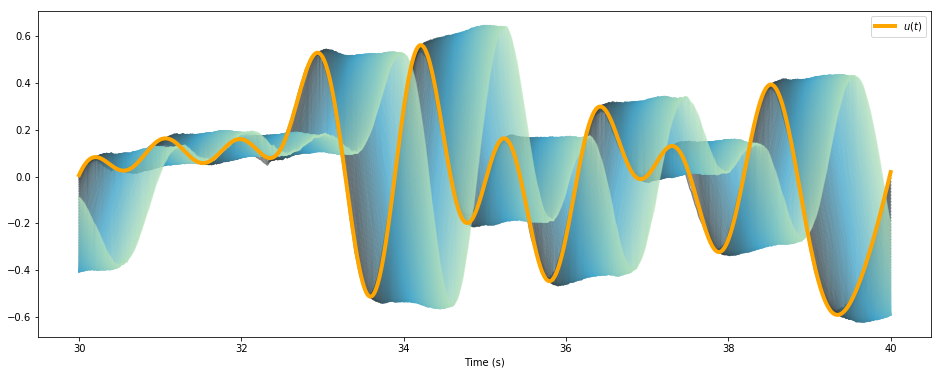

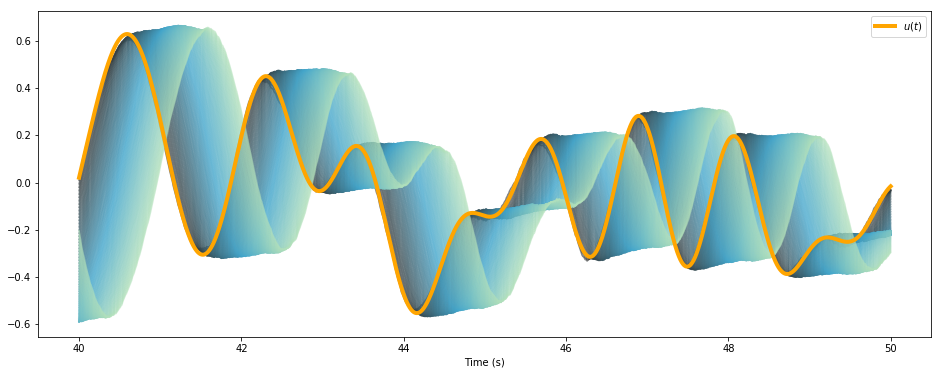

In [7]:
w = np.linspace(0, 1, 100)  # window to decode (normalized by theta)
tau_probe = 0.05

from scipy.special import legendre
d = np.asarray([legendre(i)(2*w - 1) for i in range(len(sys))])

# Trick to determine the postsynaptic current for each neuron
# without the encoders / gains / biases
synaptic_driver = (
    sim.data[p_stim].dot(conn_in.transform.T) + 
    sim.data[p_x].dot(conn_rec.transform.T))

X = nengo.Lowpass(tau).filt(synaptic_driver, y0=0, axis=0, dt=sim.dt)

X_filt = nengo.Lowpass(tau_probe).filt(X, y0=0, axis=0, dt=sim.dt)
u_filt = nengo.Lowpass(tau_probe).filt(sim.data[p_stim], y0=0, dt=sim.dt)
Y_filt = X_filt.dot(d)

t_per_plot = 10
for i in range(sim_t // t_per_plot):
    t_sl = (sim.trange() >= t_per_plot * i) & (sim.trange() < t_per_plot * (i+1))

    plt.figure(figsize=(16, 6))
    colors = sns.color_palette('GnBu_d', d.shape[1])
    for i in range(d.shape[1]):
        plt.plot(sim.trange()[t_sl], Y_filt[t_sl, i], c=colors[i], alpha=0.6)
    plt.plot(sim.trange()[t_sl], u_filt[t_sl], label="$u(t)$", lw=4,
             color='orange')
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

In [8]:
if use_loihi:
    # Debugging to ensure that recurrent connections are happening on chip
    print(sim.model.split.passthrough.to_add)

{<Connection at 0x7f5637779828 from <Ensemble "1"> to <Ensemble "3">>, <Connection at 0x7f5637779048 from <Node (unlabeled) at 0x7f56377797f0> to <Ensemble "2">>, <Connection at 0x7f5649efa080 from <Ensemble "2"> to <Ensemble "2">>, <Connection at 0x7f5637779080 from <Node (unlabeled) at 0x7f56377797f0> to <Ensemble "0">>, <Connection at 0x7f56377790b8 from <Node (unlabeled) at 0x7f56377797f0> to <Ensemble "5">>, <Connection at 0x7f5649efa0f0 from <Ensemble "3"> to <Ensemble "3">>, <Connection at 0x7f5637779908 from <Ensemble "3"> to <Ensemble "1">>, <Connection at 0x7f56377790f0 from <Node (unlabeled) at 0x7f56377797f0> to <Ensemble "3">>, <Connection at 0x7f5649efa128 from <Ensemble "3"> to <Ensemble "5">>, <Connection at 0x7f5637779128 from <Node (unlabeled) at 0x7f56377797f0> to <Ensemble "4">>, <Connection at 0x7f5649efa160 from <Ensemble "3"> to <Ensemble "4">>, <Connection at 0x7f5637779160 from <Node (unlabeled) at 0x7f56377797f0> to <Ensemble "1">>, <Connection at 0x7f56377791